/tmp/ipython-input-3887598623.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2018-01-01', end='2023-12-31', freq='M')


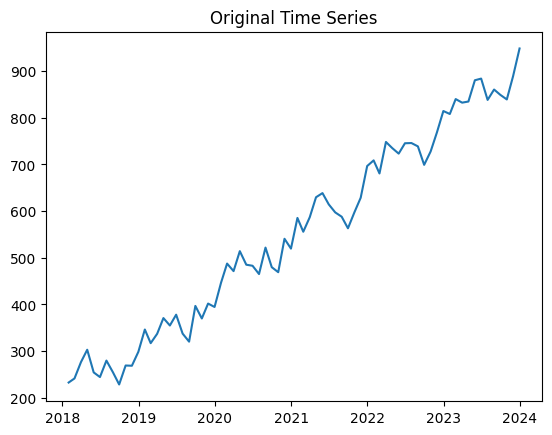

🔹 Linear Regression → MAE: 0.0 RMSE: 0.0
🔹 Random Forest     → MAE: 125.84 RMSE: 132.98
🔹 XGBoost           → MAE: 136.08 RMSE: 143.81


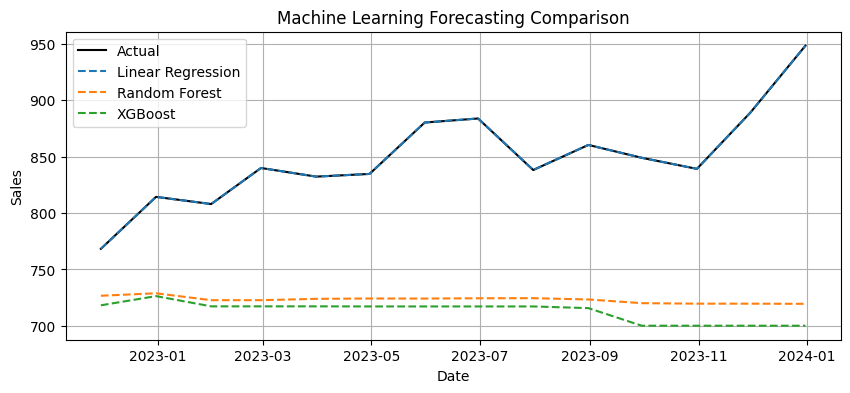

/tmp/ipython-input-3887598623.py:127: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(), periods=future_steps, freq='M')


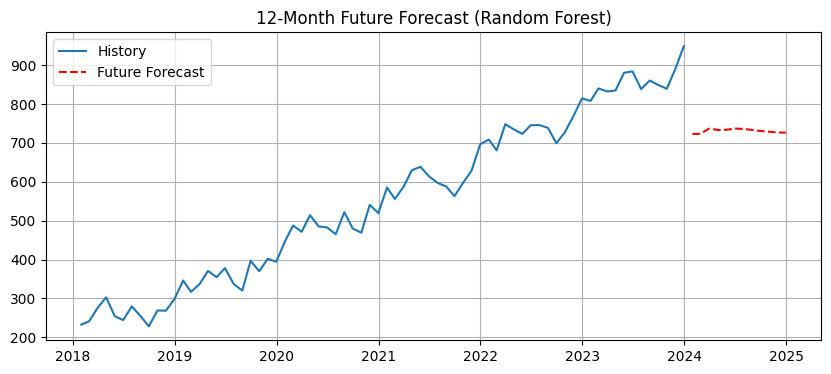

✅ ML-based Time Series Forecasting Complete!


In [1]:
# Time Series Forecasting using Machine Learning Models
# Requirements: pandas, numpy, matplotlib, scikit-learn
# Optional: xgboost (pip install xgboost)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False

# ---------------------------------------
# 1. Generate or Load Time Series Data
# ---------------------------------------
np.random.seed(42)
date_rng = pd.date_range(start='2018-01-01', end='2023-12-31', freq='M')
sales = 200 + 10*np.arange(len(date_rng)) + 40*np.sin(2*np.pi*date_rng.month/12) + np.random.normal(0, 25, len(date_rng))

df = pd.DataFrame({'Date': date_rng, 'Sales': sales})
df.set_index('Date', inplace=True)

plt.plot(df['Sales'])
plt.title("Original Time Series")
plt.show()

# ---------------------------------------
# 2. Feature Engineering for ML
# ---------------------------------------
data = df.copy()

# Create Lag Features
data['Lag1'] = data['Sales'].shift(1)
data['Lag2'] = data['Sales'].shift(2)
data['Lag3'] = data['Sales'].shift(3)

# Moving Averages
data['MA3'] = data['Sales'].rolling(window=3).mean()
data['MA6'] = data['Sales'].rolling(window=6).mean()

# Time-based Features
data['Month'] = data.index.month
data['Year'] = data.index.year

# Drop missing rows
data = data.dropna()

# ---------------------------------------
# 3. Train-Test Split
# ---------------------------------------
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

X_train = train.drop(['Sales'], axis=1)
y_train = train['Sales']

X_test = test.drop(['Sales'], axis=1)
y_test = test['Sales']

# ---------------------------------------
# 4. Machine Learning Models
# ---------------------------------------

# 📌 Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# 📌 Model 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# 📌 Model 3: XGBoost (optional)
if xgb_available:
    xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
else:
    xgb_pred = None

# ---------------------------------------
# 5. Evaluation Function
# ---------------------------------------
def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return mae, rmse

lr_mae, lr_rmse = evaluate(y_test, lr_pred)
rf_mae, rf_rmse = evaluate(y_test, rf_pred)

print("🔹 Linear Regression → MAE:", round(lr_mae,2), "RMSE:", round(lr_rmse,2))
print("🔹 Random Forest     → MAE:", round(rf_mae,2), "RMSE:", round(rf_rmse,2))

if xgb_pred is not None:
    xgb_mae, xgb_rmse = evaluate(y_test, xgb_pred)
    print("🔹 XGBoost           → MAE:", round(xgb_mae,2), "RMSE:", round(xgb_rmse,2))

# ---------------------------------------
# 6. Plot Predictions vs Actual
# ---------------------------------------
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label='Actual', color='black')
plt.plot(y_test.index, lr_pred, label='Linear Regression', linestyle='--')
plt.plot(y_test.index, rf_pred, label='Random Forest', linestyle='--')

if xgb_pred is not None:
    plt.plot(y_test.index, xgb_pred, label='XGBoost', linestyle='--')

plt.title("Machine Learning Forecasting Comparison")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.grid(True)
plt.show()

# ---------------------------------------
# 7. Future Forecast Using Best Model (Random Forest)
# ---------------------------------------
future_steps = 12
future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(), periods=future_steps, freq='M')

last_data = data.iloc[-3:]  # last few rows for creating lags dynamically
future_df = []

prev_values = list(last_data['Sales'])

for i in range(future_steps):
    lag1 = prev_values[-1]
    lag2 = prev_values[-2]
    lag3 = prev_values[-3]

    new_row = {
        'Lag1': lag1,
        'Lag2': lag2,
        'Lag3': lag3,
        'MA3': np.mean(prev_values[-3:]),
        'MA6': np.mean(prev_values[-6:]) if len(prev_values) >= 6 else np.mean(prev_values),
        'Month': future_dates[i].month,
        'Year': future_dates[i].year
    }

    pred = rf_model.predict(pd.DataFrame([new_row]))[0]
    future_df.append(pred)
    prev_values.append(pred)  # update list

future_df = pd.DataFrame({'Forecast': future_df}, index=future_dates)

plt.figure(figsize=(10,4))
plt.plot(df['Sales'], label='History')
plt.plot(future_df['Forecast'], label='Future Forecast', linestyle='--', color='red')
plt.title("12-Month Future Forecast (Random Forest)")
plt.legend(); plt.grid(True)
plt.show()

print("✅ ML-based Time Series Forecasting Complete!")
